In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Mon Feb 12 15:56:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 35%   61C    P3              83W / 450W |     11MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Hyper-Parameters

In [3]:
from easydict import EasyDict
hp = EasyDict()

# Data
hp.dataset = 'ffhq_256'
hp.data_root = '/home/scpark/data'
hp.test_eval = True
hp.image_channels = 3
hp.n_batch = 32

# Model
hp.custom_width_str = ""
hp.bottleneck_multiple = 0.25
hp.no_bias_above = 64
hp.num_mixtures = 10
hp.width = 384
hp.zdim = 16
hp.dec_blocks = "1x1,4m1,4x1,8m4,8x1,16m8,16x1,32m16,32x1"
hp.enc_blocks = "32x1,32d2,16x1,16d2,8x1,8d2,4x1,4d4,1x1"

# Train
hp.lr = 0.0002
hp.wd = 0.01
hp.adam_beta1 = 0.9
hp.adam_beta2 = 0.9
hp.warmup_iters = 100
hp.ema_rate = 0.9999
hp.grad_clip = 200.0
hp.skip_threshold = 400.0

### Model

In [4]:
from model.main.vdvae import Model
from model.encoder.vdvae_encoder import Encoder
from model.decoder.vdvae_bottleneck_l1mask_swae_decoder import Decoder
from model.loss.dmol_swae_mask import Loss

from tensorboardX import SummaryWriter
from util.util import *

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(hp), Decoder(hp), Loss(hp)).to(device)
ema_model = None
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=hp.wd, lr=hp.lr, betas=(hp.adam_beta1, hp.adam_beta2))

for name, module in model.named_modules():
    if len(name.split('.')) <= 1 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 7.7281494140625
decoder 25.64813232421875
loss 0.1468658447265625
done


### Load

In [6]:
save_dir = '/data/save/lse/train_vdvae/train02.12-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, optimizer = load(save_dir, 60000, model, optimizer)

total 413876
-rw-rw-r-- 1 scpark scpark    275356  2월 12 15:56 events.out.tfevents.1707719483.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 105856838  2월 12 15:56 save_20000
-rw-rw-r-- 1 scpark scpark 105856838  2월 12 15:43 save_10000
-rw-rw-r-- 1 scpark scpark 105846742  2월 12 15:31 save_0
-rw-rw-r-- 1 scpark scpark     21730  2월 12 15:31 events.out.tfevents.1707719353.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark     52240  2월 12 15:29 events.out.tfevents.1707719017.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 105855530  2월 12 15:28 save_3861
-rw-rw-r-- 1 scpark scpark        40  2월 12 15:23 events.out.tfevents.1707718786.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark     16195  2월 12 15:22 events.out.tfevents.1707718848.scpark-X299-WU8


### Dataset

In [7]:
from torch.utils.data import DataLoader
from data.vdvae_data import set_up_data

hp, data_train, data_valid_or_test, preprocess_fn = set_up_data(hp)
hp.image_size = 32
train_loader = DataLoader(data_train, batch_size=hp.n_batch, drop_last=True, pin_memory=True)
print(train_loader)

DOING TEST


### Train

In [8]:
import time
from util.train_helpers import update_ema

def training_step(H, data_input, target, model, ema_model, optimizer):
    model.train()
    model.zero_grad()
    data = {'x': data_input,
            'x_target': target}
    stats = model.forward(data, mask_loss_weight=1.0)
    stats['elbo'].backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), H.grad_clip).item()
    distortion_nans = torch.isnan(stats['distortion']).sum()
    rate_nans = torch.isnan(stats['rate']).sum()
    stats.update(dict(rate_nans=0 if rate_nans == 0 else 1, distortion_nans=0 if distortion_nans == 0 else 1))

    skipped_updates = 1
    # only update if no rank has a nan and if the grad norm is below a specific threshold
    if stats['distortion_nans'] == 0 and stats['rate_nans'] == 0 and (H.skip_threshold == -1 or grad_norm < H.skip_threshold):
        optimizer.step()
        skipped_updates = 0
        if ema_model is not None:
            update_ema(model, ema_model, H.ema_rate)

    stats.update(skipped_updates=skipped_updates, grad_norm=grad_norm)
    return stats

def show_samples(model, N):
    model.eval()
    with torch.no_grad():
        samples = model.sample(N)
    plt.figure(figsize=[18, 4])
    for i in range(len(samples)):
        plt.subplot(1, N, i+1)
        plt.imshow(samples[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

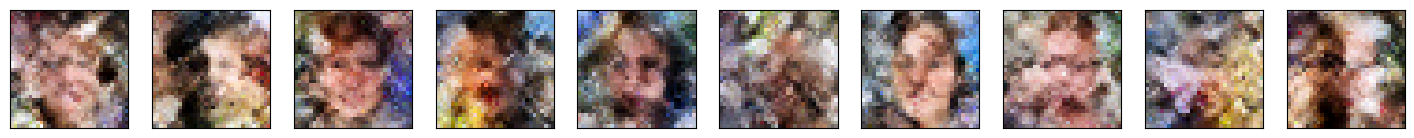

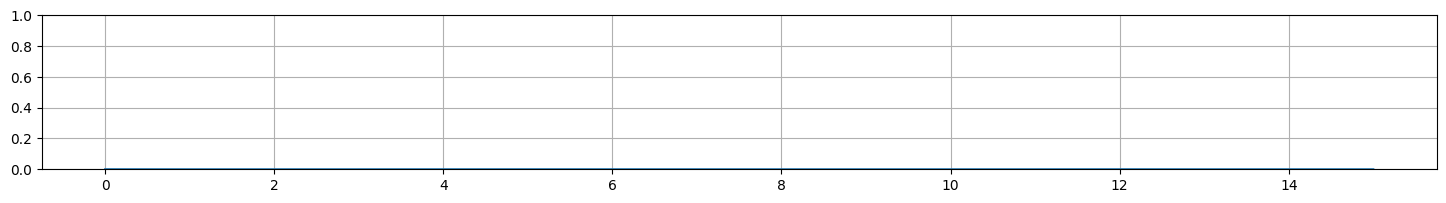

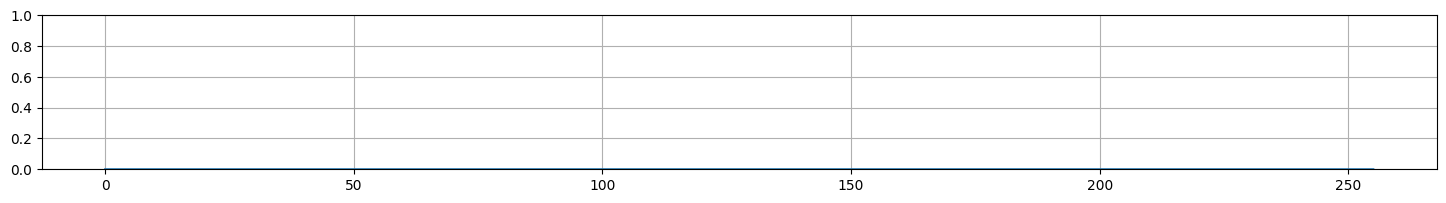

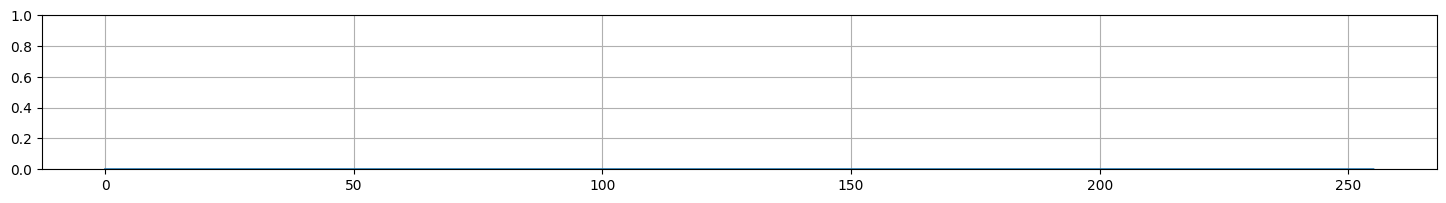

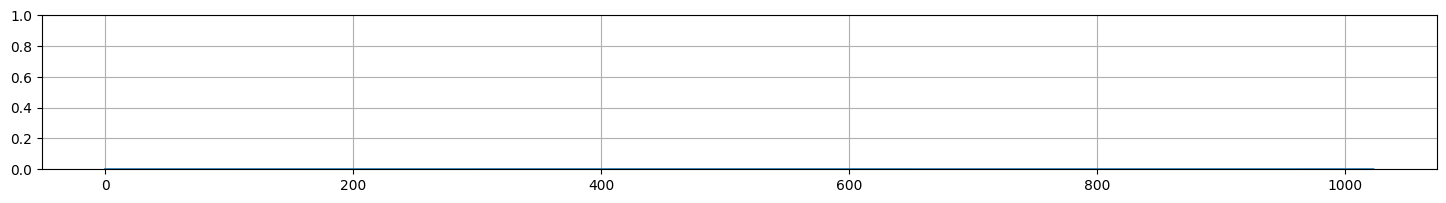

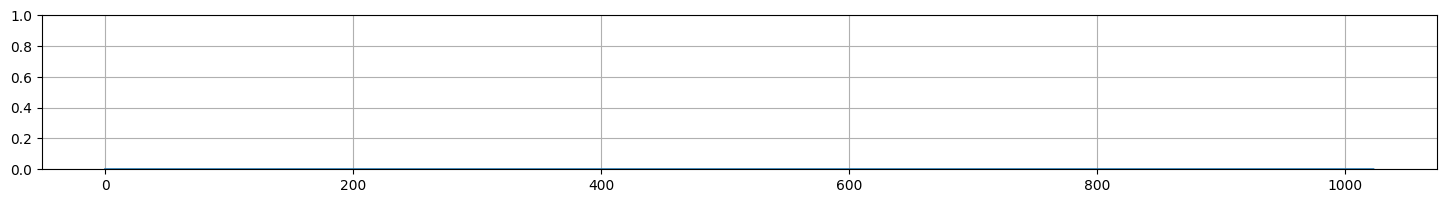

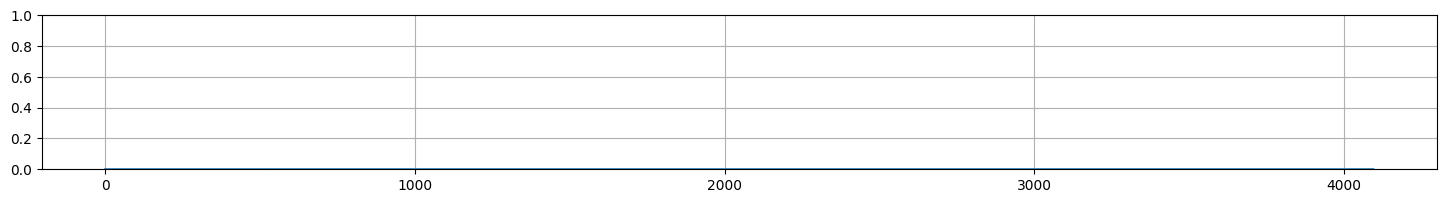

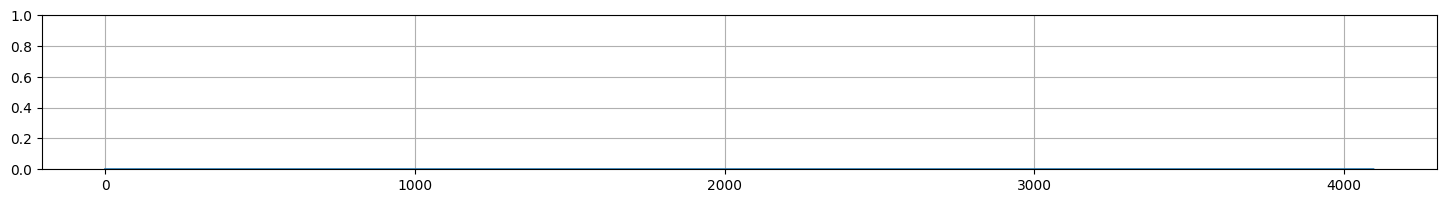

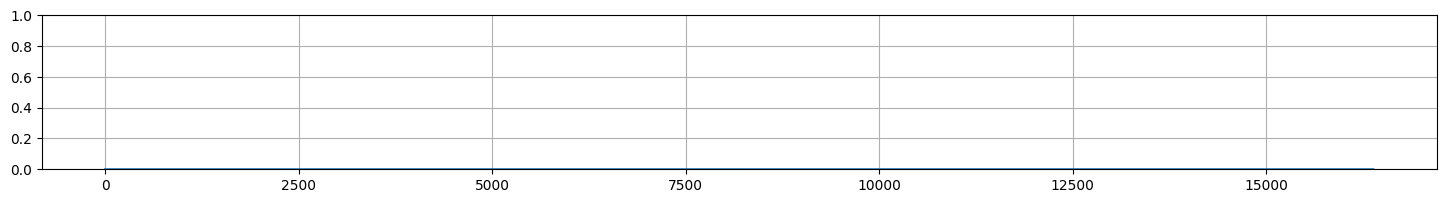

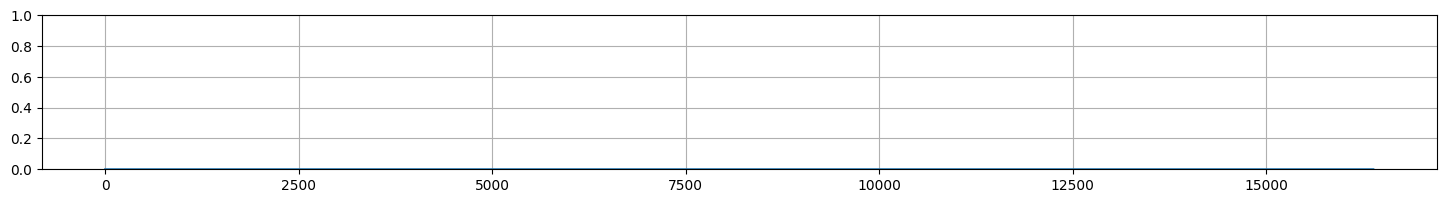

28810 elbo 3.2555880546569824


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
from IPython import display
import torchvision.transforms as transforms

resize = transforms.Resize((hp.image_size, hp.image_size))

while True:
    for x in train_loader:
        x[0] = resize(x[0].permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        data_input, target = preprocess_fn(x)
        data_input = data_input.to(device)
        target = target.to(device)
        stats = training_step(hp, data_input, target, model, ema_model, optimizer)

        if step % 10 == 0:
            print(step, 'elbo', stats['elbo'].item())
            writer.add_scalar('elbo', stats['elbo'].item(), step)
            writer.add_scalar('distortion', stats['distortion'].item(), step)
            writer.add_scalar('rate', stats['rate'].item(), step)
            
        if step % 100 == 0:
            display.clear_output()
            show_samples(model, 10)
            
            for dec_block in model.decoder.decoder.dec_blocks:
                mask = torch.sigmoid(dec_block.mask.reshape(-1)).data.cpu().numpy()
                plt.figure(figsize=[18, 2])
                plt.plot(mask)
                plt.grid()
                plt.ylim([0, 1])
                plt.show()
            
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        

In [11]:
save(save_dir, step, model, optimizer)
print('done')

done


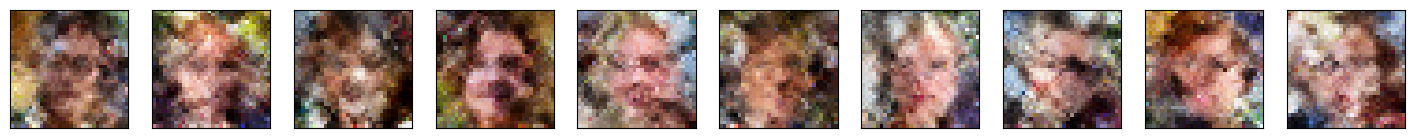

In [12]:
import matplotlib.pyplot as plt
show_samples(model, 10)